In [1]:
# install dependencies: 
!python -m pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-e7aiwbm9/pyyaml_356d2a074ff347a5aabfbd5c544958a5/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 185, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 201, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/pyth

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import pandas as pd
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [3]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
23842,00006289_005.png,Pneumonia,5,6289,59,F,AP,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_003/images/00006289_...
72082,00017747_043.png,Consolidation,43,17747,30,M,AP,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_008/images/00017747_...
81965,00020166_000.png,No Finding,0,20166,56,M,PA,3056,2508,0.139,0.139,NaN,/kaggle/input/data/images_009/images/00020166_...


In [4]:
list(all_image_paths.items())[1]

('00004833_016.png', '/kaggle/input/data/images_003/images/00004833_016.png')

# Antes de tudo precisamos reescrever a BBOX no formato json

In [5]:
bbox_csv = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
bbox_csv

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [6]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Effusion': 2,
 'Infiltrate': 3,
 'Mass': 4,
 'Nodule': 5,
 'Pneumonia': 6,
 'Pneumothorax': 7}

In [7]:
bbox_csv_copy = bbox_csv.copy(deep=True)
#bbox_csv = bbox_csv[~bbox_csv['Finding Label'].isin(['Atelectasis', 'Nodule', 'Mass', 'Pneumothorax'])]
bbox_csv = bbox_csv[~bbox_csv['Finding Label'].isin(['Nodule', 'Mass', 'Pneumothorax'])]
bbox_csv['Finding Label'].value_counts()

Finding Label
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Name: count, dtype: int64

In [8]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Effusion': 2,
 'Infiltrate': 3,
 'Pneumonia': 4}

In [9]:
list_exc = []
cats_exc = {k: bbox_csv['Finding Label'].value_counts()[k] - bbox_csv['Finding Label'].value_counts().min() for k in categorys}

for cat in categorys:
    count = 0
    df_catx = bbox_csv[bbox_csv['Finding Label'] == cat]
    for i, r in df_catx.iterrows():
        if len(bbox_csv[bbox_csv['Image Index'] == r['Image Index']]['Image Index'].to_list()) == 1 and count < cats_exc[cat]:
            list_exc.append(r['Image Index'])
            count += 1

df_new = bbox_csv[~bbox_csv['Image Index'].isin(list_exc)]
df_new

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
60,00007676_002.png,Atelectasis,360.677966,439.629386,82.440678,136.677966,NaN,NaN,NaN
61,00005089_002.png,Atelectasis,648.135593,574.137861,263.593220,188.745763,NaN,NaN,NaN
62,00020857_008.png,Atelectasis,190.372881,571.968369,562.983051,202.847458,NaN,NaN,NaN
63,00012291_008.png,Atelectasis,232.677966,631.629386,226.711864,74.847458,NaN,NaN,NaN
64,00018762_002.png,Atelectasis,603.661017,616.786447,257.084746,81.355932,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [10]:
df_new['Finding Label'].value_counts()

Finding Label
Atelectasis     120
Cardiomegaly    120
Effusion        120
Infiltrate      120
Pneumonia       120
Name: count, dtype: int64

In [11]:
bbox_csv = df_new.copy()

dataentry = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
dataentry

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [12]:
train_val_list_txt = pd.read_csv('/kaggle/input/data/train_val_list.txt', sep=' ', header=None)
train_val_list_txt

,0
0,00000001_000.png
1,00000001_001.png
2,00000001_002.png
3,00000002_000.png
4,00000004_000.png
...,...
86519,00030789_000.png
86520,00030793_000.png
86521,00030795_000.png
86522,00030801_000.png


In [13]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Effusion': 2,
 'Infiltrate': 3,
 'Pneumonia': 4}

In [14]:
bbox_csv['image_id'] = bbox_csv.apply(lambda x: x['Image Index'].split('.')[0], axis = 1)
bbox_csv['category_id'] = bbox_csv.apply(lambda x: category_ids[x['Finding Label']], axis = 1)
bbox_csv['height'] = None
bbox_csv['width'] = None

for i in bbox_csv['Image Index']:
    if i in dataentry['Image Index'].values:
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['height']] = dataentry.loc[dataentry['Image Index'] == i, ['Height]']].values[0][0]
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['width']] = dataentry.loc[dataentry['Image Index'] == i, ['OriginalImage[Width']].values[0][0]

bbox_csv

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,image_id,category_id,height,width
60,00007676_002.png,Atelectasis,360.677966,439.629386,82.440678,136.677966,NaN,NaN,NaN,00007676_002,0,2048,2500
61,00005089_002.png,Atelectasis,648.135593,574.137861,263.593220,188.745763,NaN,NaN,NaN,00005089_002,0,2048,2500
62,00020857_008.png,Atelectasis,190.372881,571.968369,562.983051,202.847458,NaN,NaN,NaN,00020857_008,0,2544,3056
63,00012291_008.png,Atelectasis,232.677966,631.629386,226.711864,74.847458,NaN,NaN,NaN,00012291_008,0,2991,2990
64,00018762_002.png,Atelectasis,603.661017,616.786447,257.084746,81.355932,NaN,NaN,NaN,00018762_002,0,2991,2506
...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN,00029464_015,0,2021,2021
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN,00025769_001,0,2544,3056
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN,00016837_002,0,2446,2592
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN,00020124_003,0,2991,2754


#####

# REDUZINDO TAMANHO PARA 640x640 E FORMATANDO PARA YOLO

In [15]:
import os
import numpy as np
import pandas as pd
import ast
import torch
import PIL
from tqdm.auto import tqdm
import shutil as sh
from pathlib import Path
import random

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
display.clear_output()

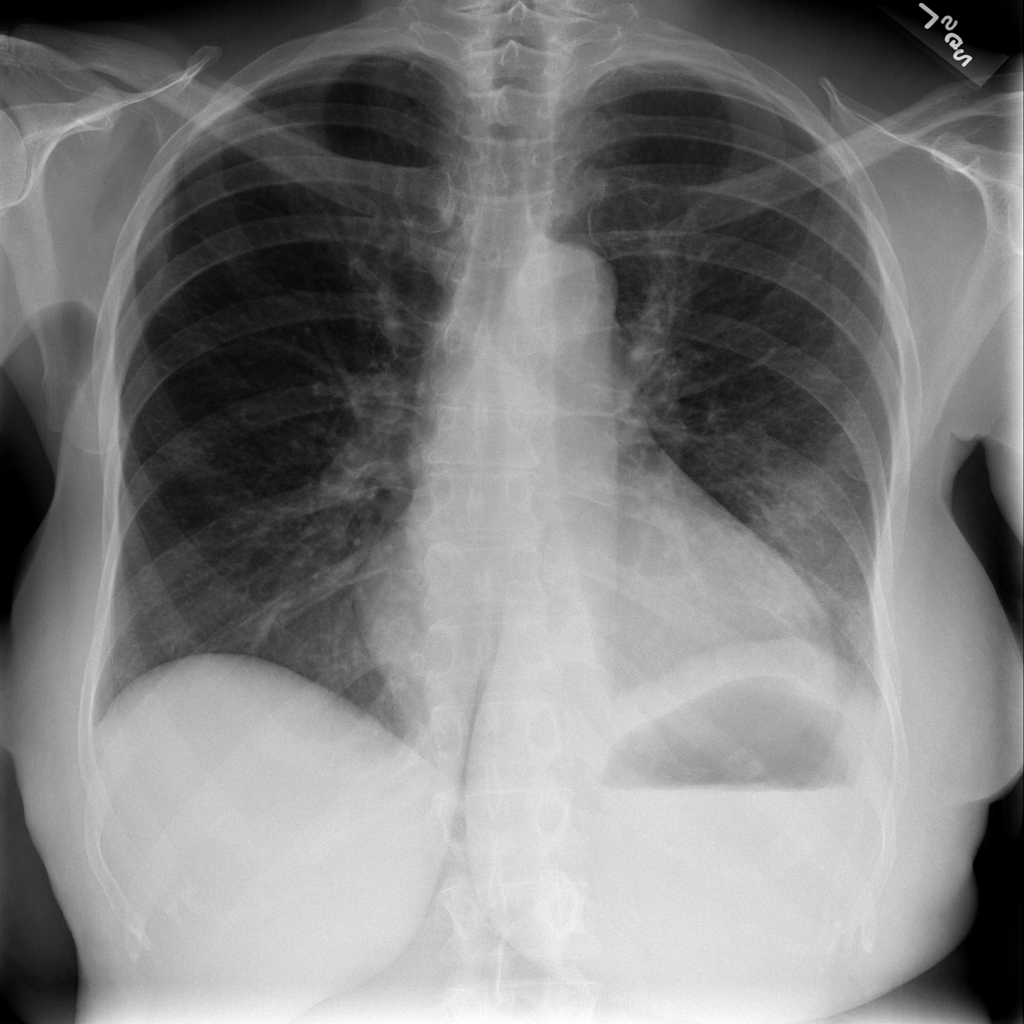

In [16]:
DATA_DIR = Path('../input/data')
img_list = [x for x in glob(os.path.join('/kaggle/input/data', 'images*', '*', '*.png'))]
pickone = random.choice(img_list)
display.Image(pickone)

In [17]:
print(f"Found {len(img_list)} images files in {DATA_DIR}")

img = PIL.Image.open(pickone)
IMAGE_HEIGHT, IMAGE_WIDTH = img.size
num_channels = len(img.mode)
print("Image size: {}".format((IMAGE_HEIGHT, IMAGE_WIDTH)))
print("Num channels: {}".format(num_channels))

Found 112120 images files in ../input/data
Image size: (1024, 1024)
Num channels: 1


In [18]:
try:
    bbox_csv.drop(bbox_csv.iloc[:, 6:9], axis=1, inplace=True)
    bbox_csv.drop(bbox_csv.iloc[:, 6:9], axis=1, inplace=True)
    bbox_csv.drop(bbox_csv.iloc[:, 6:9], axis=1, inplace=True)
except: 
    pass
bbox_csv

,Image Index,Finding Label,Bbox [x,y,w,h]
60,00007676_002.png,Atelectasis,360.677966,439.629386,82.440678,136.677966
61,00005089_002.png,Atelectasis,648.135593,574.137861,263.593220,188.745763
62,00020857_008.png,Atelectasis,190.372881,571.968369,562.983051,202.847458
63,00012291_008.png,Atelectasis,232.677966,631.629386,226.711864,74.847458
64,00018762_002.png,Atelectasis,603.661017,616.786447,257.084746,81.355932
...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778


In [19]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A
# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random, itertools
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from random import sample
from PIL import Image as im
from matplotlib.image import imread
pd.set_option('display.max_columns', None)

In [20]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

In [21]:
!mkdir novas_imagens

In [22]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data', 'images*', '*', '*.png'))}

bbox_csv['path'] = bbox_csv['Image Index'].map(all_image_paths.get)
bbox_csv['class_id'] = bbox_csv.apply(lambda x: category_ids[x['Finding Label']], axis=1)
#bbox_csv.drop(['Image Index', 'Finding Label', 'x', 'y', 'w', 'h', 'class_id'], axis=1, inplace=True)
bbox_csv

,Image Index,Finding Label,Bbox [x,y,w,h],path,class_id
60,00007676_002.png,Atelectasis,360.677966,439.629386,82.440678,136.677966,/kaggle/input/data/images_004/images/00007676_...,0
61,00005089_002.png,Atelectasis,648.135593,574.137861,263.593220,188.745763,/kaggle/input/data/images_003/images/00005089_...,0
62,00020857_008.png,Atelectasis,190.372881,571.968369,562.983051,202.847458,/kaggle/input/data/images_009/images/00020857_...,0
63,00012291_008.png,Atelectasis,232.677966,631.629386,226.711864,74.847458,/kaggle/input/data/images_006/images/00012291_...,0
64,00018762_002.png,Atelectasis,603.661017,616.786447,257.084746,81.355932,/kaggle/input/data/images_009/images/00018762_...,0
...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,/kaggle/input/data/images_012/images/00029464_...,0
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,/kaggle/input/data/images_011/images/00025769_...,0
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,/kaggle/input/data/images_008/images/00016837_...,0
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,/kaggle/input/data/images_009/images/00020124_...,0


In [23]:
for j, i in bbox_csv.iterrows():
    # Ler a imagem
    image = cv2.imread(i['path'])
    
    new_image_id = i['Image Index'].split('.')[0] + '_new.png'
    diretorio = f"/kaggle/working/novas_imagens/{new_image_id}"

    # Redimensionar a imagem para uma nova largura e altura
    nova_largura = 640
    nova_altura = 640
    image_redimensionada = cv2.resize(image, (nova_largura, nova_altura))

    # Calcular fatores de escala para redimensionar as bounding boxes
    fator_escala_x = nova_largura / image.shape[1]
    fator_escala_y = nova_altura / image.shape[0]

    # Redimensionar as bounding boxes no DataFrame
    bbox_csv.at[j,'Bbox [x'] *= fator_escala_x
    bbox_csv.at[j,'y'] *= fator_escala_y
    bbox_csv.at[j,'w'] *= fator_escala_x
    bbox_csv.at[j,'h]'] *= fator_escala_y
    
    # Salvar a imagem
    cv2.imwrite(diretorio, image_redimensionada)
    
    bbox_csv.at[j, 'Image Index'] = new_image_id
    bbox_csv.at[j, 'path'] = diretorio

bbox_csv

,Image Index,Finding Label,Bbox [x,y,w,h],path,class_id
60,00007676_002_new.png,Atelectasis,225.423729,274.768366,51.525424,85.423729,/kaggle/working/novas_imagens/00007676_002_new...,0
61,00005089_002_new.png,Atelectasis,405.084746,358.836163,164.745763,117.966102,/kaggle/working/novas_imagens/00005089_002_new...,0
62,00020857_008_new.png,Atelectasis,118.983051,357.480231,351.864407,126.779661,/kaggle/working/novas_imagens/00020857_008_new...,0
63,00012291_008_new.png,Atelectasis,145.423729,394.768366,141.694915,46.779661,/kaggle/working/novas_imagens/00012291_008_new...,0
64,00018762_002_new.png,Atelectasis,377.288136,385.491530,160.677966,50.847458,/kaggle/working/novas_imagens/00018762_002_new...,0
...,...,...,...,...,...,...,...,...
979,00029464_015_new.png,Atelectasis,124.337782,220.562967,384.711111,201.955556,/kaggle/working/novas_imagens/00029464_015_new...,0
980,00025769_001_new.png,Atelectasis,438.648893,357.807411,64.711111,39.822222,/kaggle/working/novas_imagens/00025769_001_new...,0
981,00016837_002_new.png,Atelectasis,88.071115,411.851855,169.955556,59.022222,/kaggle/working/novas_imagens/00016837_002_new...,0
982,00020124_003_new.png,Atelectasis,109.404449,362.785189,152.888889,64.711111,/kaggle/working/novas_imagens/00020124_003_new...,0


In [24]:
# Convertendo COCO para YOLO (class_id, center_x, center_y, width, height) (normalizados)
bbox_csv = bbox_csv.rename (columns = {'Bbox [x': 'x', 'h]': 'h'})
bbox_csv['x'] = (bbox_csv['x'] + bbox_csv['w']/2) / 640
bbox_csv['y'] = (bbox_csv['y'] + bbox_csv['h']/2) / 640
bbox_csv['w'] = bbox_csv['w'] / 640
bbox_csv['h'] = bbox_csv['h'] / 640
bbox_csv

,Image Index,Finding Label,x,y,w,h,path,class_id
60,00007676_002_new.png,Atelectasis,0.392479,0.496063,0.080508,0.133475,/kaggle/working/novas_imagens/00007676_002_new...,0
61,00005089_002_new.png,Atelectasis,0.761653,0.652843,0.257415,0.184322,/kaggle/working/novas_imagens/00005089_002_new...,0
62,00020857_008_new.png,Atelectasis,0.460805,0.657609,0.549788,0.198093,/kaggle/working/novas_imagens/00020857_008_new...,0
63,00012291_008_new.png,Atelectasis,0.337924,0.653372,0.221398,0.073093,/kaggle/working/novas_imagens/00012291_008_new...,0
64,00018762_002_new.png,Atelectasis,0.715042,0.642055,0.251059,0.079449,/kaggle/working/novas_imagens/00018762_002_new...,0
...,...,...,...,...,...,...,...,...
979,00029464_015_new.png,Atelectasis,0.494833,0.502407,0.601111,0.315556,/kaggle/working/novas_imagens/00029464_015_new...,0
980,00025769_001_new.png,Atelectasis,0.735944,0.590185,0.101111,0.062222,/kaggle/working/novas_imagens/00025769_001_new...,0
981,00016837_002_new.png,Atelectasis,0.270389,0.689630,0.265556,0.092222,/kaggle/working/novas_imagens/00016837_002_new...,0
982,00020124_003_new.png,Atelectasis,0.290389,0.617407,0.238889,0.101111,/kaggle/working/novas_imagens/00020124_003_new...,0


In [25]:
bbox_csv['file_name'] = bbox_csv['path']
bbox_csv['class_id'] = bbox_csv.apply(lambda x: category_ids[x['Finding Label']], axis=1)
bbox_csv['boxes'] = bbox_csv.apply(lambda row: [row.class_id, row.x, row.y, row.w, row.h], axis=1)
#bbox_csv.drop(['Image Index', 'Finding Label', 'x', 'y', 'w', 'h', 'class_id'], axis=1, inplace=True)
bbox_csv

,Image Index,Finding Label,x,y,w,h,path,class_id,file_name,boxes
60,00007676_002_new.png,Atelectasis,0.392479,0.496063,0.080508,0.133475,/kaggle/working/novas_imagens/00007676_002_new...,0,/kaggle/working/novas_imagens/00007676_002_new...,"[0, 0.3924788135593221, 0.4960628606505317, 0...."
61,00005089_002_new.png,Atelectasis,0.761653,0.652843,0.257415,0.184322,/kaggle/working/novas_imagens/00005089_002_new...,0,/kaggle/working/novas_imagens/00005089_002_new...,"[0, 0.7616525423728814, 0.6528425216674805, 0...."
62,00020857_008_new.png,Atelectasis,0.460805,0.657609,0.549788,0.198093,/kaggle/working/novas_imagens/00020857_008_new...,0,/kaggle/working/novas_imagens/00020857_008_new...,"[0, 0.4608050847457627, 0.6576094708200231, 0...."
63,00012291_008_new.png,Atelectasis,0.337924,0.653372,0.221398,0.073093,/kaggle/working/novas_imagens/00012291_008_new...,0,/kaggle/working/novas_imagens/00012291_008_new...,"[0, 0.33792372881355953, 0.6533721826844301, 0..."
64,00018762_002_new.png,Atelectasis,0.715042,0.642055,0.251059,0.079449,/kaggle/working/novas_imagens/00018762_002_new...,0,/kaggle/working/novas_imagens/00018762_002_new...,"[0, 0.7150423728813565, 0.6420550912113514, 0...."
...,...,...,...,...,...,...,...,...,...,...
979,00029464_015_new.png,Atelectasis,0.494833,0.502407,0.601111,0.315556,/kaggle/working/novas_imagens/00029464_015_new...,0,/kaggle/working/novas_imagens/00029464_015_new...,"[0, 0.4948333401150176, 0.502407413058811, 0.6..."
980,00025769_001_new.png,Atelectasis,0.735944,0.590185,0.101111,0.062222,/kaggle/working/novas_imagens/00025769_001_new...,0,/kaggle/working/novas_imagens/00025769_001_new...,"[0, 0.735944451226129, 0.5901851908365886, 0.1..."
981,00016837_002_new.png,Atelectasis,0.270389,0.689630,0.265556,0.092222,/kaggle/working/novas_imagens/00016837_002_new...,0,/kaggle/working/novas_imagens/00016837_002_new...,"[0, 0.2703888956705728, 0.6896296352810329, 0...."
982,00020124_003_new.png,Atelectasis,0.290389,0.617407,0.238889,0.101111,/kaggle/working/novas_imagens/00020124_003_new...,0,/kaggle/working/novas_imagens/00020124_003_new...,"[0, 0.29038889567057324, 0.6174074130588105, 0..."


####

In [26]:
bbox_csv['image_id'] = bbox_csv.apply(lambda x: x['Image Index'].split('.')[0], axis = 1)
bbox_csv['category_id'] = bbox_csv.apply(lambda x: category_ids[x['Finding Label']], axis = 1)
bbox_csv['height'] = None
bbox_csv['width'] = None

for i in bbox_csv['Image Index']:
    if i in dataentry['Image Index'].values:
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['height']] = dataentry.loc[dataentry['Image Index'] == i, ['Height]']].values[0][0]
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['width']] = dataentry.loc[dataentry['Image Index'] == i, ['OriginalImage[Width']].values[0][0]

bbox_csv

,Image Index,Finding Label,x,y,w,h,path,class_id,file_name,boxes,image_id,category_id,height,width
60,00007676_002_new.png,Atelectasis,0.392479,0.496063,0.080508,0.133475,/kaggle/working/novas_imagens/00007676_002_new...,0,/kaggle/working/novas_imagens/00007676_002_new...,"[0, 0.3924788135593221, 0.4960628606505317, 0....",00007676_002_new,0,None,None
61,00005089_002_new.png,Atelectasis,0.761653,0.652843,0.257415,0.184322,/kaggle/working/novas_imagens/00005089_002_new...,0,/kaggle/working/novas_imagens/00005089_002_new...,"[0, 0.7616525423728814, 0.6528425216674805, 0....",00005089_002_new,0,None,None
62,00020857_008_new.png,Atelectasis,0.460805,0.657609,0.549788,0.198093,/kaggle/working/novas_imagens/00020857_008_new...,0,/kaggle/working/novas_imagens/00020857_008_new...,"[0, 0.4608050847457627, 0.6576094708200231, 0....",00020857_008_new,0,None,None
63,00012291_008_new.png,Atelectasis,0.337924,0.653372,0.221398,0.073093,/kaggle/working/novas_imagens/00012291_008_new...,0,/kaggle/working/novas_imagens/00012291_008_new...,"[0, 0.33792372881355953, 0.6533721826844301, 0...",00012291_008_new,0,None,None
64,00018762_002_new.png,Atelectasis,0.715042,0.642055,0.251059,0.079449,/kaggle/working/novas_imagens/00018762_002_new...,0,/kaggle/working/novas_imagens/00018762_002_new...,"[0, 0.7150423728813565, 0.6420550912113514, 0....",00018762_002_new,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,00029464_015_new.png,Atelectasis,0.494833,0.502407,0.601111,0.315556,/kaggle/working/novas_imagens/00029464_015_new...,0,/kaggle/working/novas_imagens/00029464_015_new...,"[0, 0.4948333401150176, 0.502407413058811, 0.6...",00029464_015_new,0,None,None
980,00025769_001_new.png,Atelectasis,0.735944,0.590185,0.101111,0.062222,/kaggle/working/novas_imagens/00025769_001_new...,0,/kaggle/working/novas_imagens/00025769_001_new...,"[0, 0.735944451226129, 0.5901851908365886, 0.1...",00025769_001_new,0,None,None
981,00016837_002_new.png,Atelectasis,0.270389,0.689630,0.265556,0.092222,/kaggle/working/novas_imagens/00016837_002_new...,0,/kaggle/working/novas_imagens/00016837_002_new...,"[0, 0.2703888956705728, 0.6896296352810329, 0....",00016837_002_new,0,None,None
982,00020124_003_new.png,Atelectasis,0.290389,0.617407,0.238889,0.101111,/kaggle/working/novas_imagens/00020124_003_new...,0,/kaggle/working/novas_imagens/00020124_003_new...,"[0, 0.29038889567057324, 0.6174074130588105, 0...",00020124_003_new,0,None,None


In [27]:
def to_annotation(rowbbox):
    if rowbbox['category_id'] == 8: # PARA OS CASOS QUE NÃO POSSUEM DETECÇÕES
        dict_return = {
            'file_name': str(rowbbox['Image Index']),
            'image_id': str(rowbbox['image_id']),
            'height': rowbbox['height'],
            'width': rowbbox['width'],
            'annotations': []
        }
        return dict_return
    
    dict_return = {
        'file_name': str(rowbbox['Image Index']),
        'image_id': str(rowbbox['image_id']),
        'height': rowbbox['height'],
        'width': rowbbox['width'],
        'annotations': [
            {
                'bbox': [rowbbox['x'], rowbbox['y'], rowbbox['w'], rowbbox['h']],
                'bbox_mode': 1,
                'category_id': rowbbox['category_id']
            }
        ]
    }
    return dict_return

In [28]:
list_json = []
for index, row in bbox_csv.iterrows():
    presente = False
    indice = 0
    for i in range(len(list_json)):
        if str(row['Image Index']) == list_json[i]['file_name']:
            presente = True
            indice = i
            break
    
    if presente:
        list_json[i]['annotations'].append(
            {
                'bbox': [row['x'], row['y'], row['w'], row['h']],
                'bbox_mode': 1,
                'category_id': row['category_id']
            }
        )
    else:
        list_json.append(to_annotation(row))

len(list_json)

529

In [29]:
for i in list_json:
    if i['file_name'] == '00008814_010_new.png':
        print(i)

{'file_name': '00008814_010_new.png', 'image_id': '00008814_010_new', 'height': None, 'width': None, 'annotations': [{'bbox': [0.5155555555555557, 0.4542037116156684, 0.65, 0.10333333333333301], 'bbox_mode': 1, 'category_id': 2}, {'bbox': [0.515, 0.42587037828233554, 0.6288888888888887, 0.08444444444444443], 'bbox_mode': 1, 'category_id': 3}, {'bbox': [0.5176111178927953, 0.4297592671712243, 0.653333333333333, 0.0633333333333333], 'bbox_mode': 1, 'category_id': 0}]}


In [30]:
for i in range(len(list_json)):
    for j, row in bbox_csv.iterrows():
        if list_json[i]['file_name'] == row['Image Index']:
            list_json[i]['file_name'] = row['path']
list_json[0]

{'file_name': '/kaggle/working/novas_imagens/00007676_002_new.png',
 'image_id': '00007676_002_new',
 'height': None,
 'width': None,
 'annotations': [{'bbox': [0.3924788135593221,
    0.4960628606505317,
    0.0805084745762712,
    0.13347457627118653],
   'bbox_mode': 1,
   'category_id': 0}]}

In [31]:
# To ensure bbox always remap to original image size
for i in range(len(list_json)):
    image = cv2.imread(list_json[i]['file_name'])
    list_json[i]["width"] = image.shape[1]
    list_json[i]["height"] = image.shape[0]

l = None
for i in list_json:
    if i['image_id'] == '00008814_010_new':
        l = i
l

{'file_name': '/kaggle/working/novas_imagens/00008814_010_new.png',
 'image_id': '00008814_010_new',
 'height': 640,
 'width': 640,
 'annotations': [{'bbox': [0.5155555555555557,
    0.4542037116156684,
    0.65,
    0.10333333333333301],
   'bbox_mode': 1,
   'category_id': 2},
  {'bbox': [0.515,
    0.42587037828233554,
    0.6288888888888887,
    0.08444444444444443],
   'bbox_mode': 1,
   'category_id': 3},
  {'bbox': [0.5176111178927953,
    0.4297592671712243,
    0.653333333333333,
    0.0633333333333333],
   'bbox_mode': 1,
   'category_id': 0}]}

In [32]:
listststs = {}
train_data = {}
val_data = {}
test_data = {}

for i in category_ids.values():
    listststs[i] = []
    for j in list_json:
        try:
            if j['annotations'][0]['category_id'] == i:
                listststs[i].append(j)
        except:
            if i == 8:
                listststs[i].append(j)

for i, x in listststs.items():
    train_data[i] = x[:int((len(x)+1)*.80)] #80% to training set
    val_data[i] = x[int((len(x)+1)*.80):int((len(x)+1)*.90)] #10% to val set
    test_data[i] = x[int((len(x)+1)*.90):] #10% to val set

yyy = []
xxx = []
zzz = []

for i, x in train_data.items():
    for y in x:
        yyy.append(y)

for i, x in val_data.items():
    for y in x:
        xxx.append(y)
        
for i, x in test_data.items():
    for y in x:
        zzz.append(y)

len(xxx), len(yyy), len(zzz)

(53, 424, 52)

In [33]:
import json
with open('/kaggle/working/treino.json', 'w', encoding='utf-8') as f:
    json.dump(yyy, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/val.json', 'w', encoding='utf-8') as f:
    json.dump(xxx, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/test.json', 'w', encoding='utf-8') as f:
    json.dump(zzz, f, ensure_ascii=False, indent=4)

In [34]:
valid_files = []
train_files = []
teste_files = []
for i in bbox_csv['path'].tolist():
    l = i.split('/')[-1].split('.')[0]
    if l in [yyy[i]['image_id'] for i in range(len(yyy))]:
        train_files.append(i)
    elif l in [xxx[i]['image_id'] for i in range(len(xxx))]:
        valid_files.append(i)
    elif l in [zzz[i]['image_id'] for i in range(len(zzz))]:
        teste_files.append(i)

In [35]:
bbox_csv

,Image Index,Finding Label,x,y,w,h,path,class_id,file_name,boxes,image_id,category_id,height,width
60,00007676_002_new.png,Atelectasis,0.392479,0.496063,0.080508,0.133475,/kaggle/working/novas_imagens/00007676_002_new...,0,/kaggle/working/novas_imagens/00007676_002_new...,"[0, 0.3924788135593221, 0.4960628606505317, 0....",00007676_002_new,0,None,None
61,00005089_002_new.png,Atelectasis,0.761653,0.652843,0.257415,0.184322,/kaggle/working/novas_imagens/00005089_002_new...,0,/kaggle/working/novas_imagens/00005089_002_new...,"[0, 0.7616525423728814, 0.6528425216674805, 0....",00005089_002_new,0,None,None
62,00020857_008_new.png,Atelectasis,0.460805,0.657609,0.549788,0.198093,/kaggle/working/novas_imagens/00020857_008_new...,0,/kaggle/working/novas_imagens/00020857_008_new...,"[0, 0.4608050847457627, 0.6576094708200231, 0....",00020857_008_new,0,None,None
63,00012291_008_new.png,Atelectasis,0.337924,0.653372,0.221398,0.073093,/kaggle/working/novas_imagens/00012291_008_new...,0,/kaggle/working/novas_imagens/00012291_008_new...,"[0, 0.33792372881355953, 0.6533721826844301, 0...",00012291_008_new,0,None,None
64,00018762_002_new.png,Atelectasis,0.715042,0.642055,0.251059,0.079449,/kaggle/working/novas_imagens/00018762_002_new...,0,/kaggle/working/novas_imagens/00018762_002_new...,"[0, 0.7150423728813565, 0.6420550912113514, 0....",00018762_002_new,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,00029464_015_new.png,Atelectasis,0.494833,0.502407,0.601111,0.315556,/kaggle/working/novas_imagens/00029464_015_new...,0,/kaggle/working/novas_imagens/00029464_015_new...,"[0, 0.4948333401150176, 0.502407413058811, 0.6...",00029464_015_new,0,None,None
980,00025769_001_new.png,Atelectasis,0.735944,0.590185,0.101111,0.062222,/kaggle/working/novas_imagens/00025769_001_new...,0,/kaggle/working/novas_imagens/00025769_001_new...,"[0, 0.735944451226129, 0.5901851908365886, 0.1...",00025769_001_new,0,None,None
981,00016837_002_new.png,Atelectasis,0.270389,0.689630,0.265556,0.092222,/kaggle/working/novas_imagens/00016837_002_new...,0,/kaggle/working/novas_imagens/00016837_002_new...,"[0, 0.2703888956705728, 0.6896296352810329, 0....",00016837_002_new,0,None,None
982,00020124_003_new.png,Atelectasis,0.290389,0.617407,0.238889,0.101111,/kaggle/working/novas_imagens/00020124_003_new...,0,/kaggle/working/novas_imagens/00020124_003_new...,"[0, 0.29038889567057324, 0.6174074130588105, 0...",00020124_003_new,0,None,None


In [36]:
' '.join(str(x) for x in bbox_csv.iloc[254]['boxes'])

'2 0.20529100529100539 0.4645502645502642 0.1947089947089951 0.37037037037037013'

In [37]:
row

Image Index                                   00026920_000_new.png
Finding Label                                          Atelectasis
x                                                         0.394278
y                                                         0.461852
w                                                         0.117778
h                                                         0.052222
path             /kaggle/working/novas_imagens/00026920_000_new...
class_id                                                         0
file_name        /kaggle/working/novas_imagens/00026920_000_new...
boxes            [0, 0.39427778455946194, 0.46185185750325564, ...
image_id                                          00026920_000_new
category_id                                                      0
height                                                        None
width                                                         None
Name: 983, dtype: object

In [38]:
os.makedirs('/kaggle/working/labels', exist_ok = True)
for j, row in bbox_csv.iterrows():
    fname = os.path.basename(row['path']).replace('png', 'txt')
    with open(f'labels/{fname}', 'a') as f:
        f.write(' '.join(str(x) for x in row['boxes']))
        f.write('\n')

In [39]:
import json
with open('/kaggle/working/treino.json', 'w', encoding='utf-8') as f:
    json.dump(train_files, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/val.json', 'w', encoding='utf-8') as f:
    json.dump(valid_files, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/test.json', 'w', encoding='utf-8') as f:
    json.dump(teste_files, f, ensure_ascii=False, indent=4)

In [40]:
import os
import shutil
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

os.makedirs('/kaggle/working/NIH/train/images', exist_ok = True)
os.makedirs('/kaggle/working/NIH/train/labels', exist_ok = True)
os.makedirs('/kaggle/working/NIH/valid/images', exist_ok = True)
os.makedirs('/kaggle/working/NIH/valid/labels', exist_ok = True)
os.makedirs('/kaggle/working/NIH/teste/images', exist_ok = True)
os.makedirs('/kaggle/working/NIH/teste/labels', exist_ok = True)

for files in [train_files, valid_files, teste_files]:
    for file in tqdm (files):
        fname = file.split ('/')[-1].split ('.')[0]
        if files == train_files:
            shutil.copy (file, '/kaggle/working/NIH/train/images/' + fname + '.png')
            shutil.copy (os.path.join ('labels', fname + '.txt'), '/kaggle/working/NIH/train/labels/' + fname + '.txt')
        elif files == valid_files:
            shutil.copy (file, '/kaggle/working/NIH/valid/images/' + fname + '.png')
            shutil.copy (os.path.join ('labels', fname + '.txt'), '/kaggle/working/NIH/valid/labels/' + fname + '.txt')
        elif files == teste_files:
            shutil.copy (file, '/kaggle/working/NIH/teste/images/' + fname + '.png')
            shutil.copy (os.path.join ('labels', fname + '.txt'), '/kaggle/working/NIH/teste/labels/' + fname + '.txt')

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

In [41]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /kaggle/working/NIH/train/
val: /kaggle/working/NIH/valid/

# number of classes
nc: 5

# class names
names: ["Atelectasia","Cardiomegalia", "Efusão", "Infiltração", "Pneumonia"]
"""

with open("nih.yaml", "w") as f:
    f.write(CONFIG)

In [42]:
#!zip -r /kaggle/working/novas_imagens.zip /kaggle/working/novas_imagens

In [43]:
_df = {'file_name': [], 'category_id': [], 'bbox': []}
_df
for j in teste_files:
    _temp_df = bbox_csv[bbox_csv['file_name'] == j]
    for i, r in _temp_df.iterrows():
        _df['file_name'].append(r['file_name'])
        _df['category_id'].append(r['boxes'][0])
        _df['bbox'].append(r['boxes'][1:])
_df = pd.DataFrame(_df)
_df.to_csv('teste_bbox.csv', index=False, sep=';')
_df

,file_name,category_id,bbox
0,/kaggle/working/novas_imagens/00015719_005_new...,1,"[0.5883597883597881, 0.6359788359788359, 0.488..."
1,/kaggle/working/novas_imagens/00028607_000_new...,1,"[0.6375661375661382, 0.5116402116402119, 0.485..."
2,/kaggle/working/novas_imagens/00004893_085_new...,1,"[0.6031746031746035, 0.5253968253968252, 0.452..."
3,/kaggle/working/novas_imagens/00001373_039_new...,1,"[0.5291005291005293, 0.7285714285714282, 0.550..."
4,/kaggle/working/novas_imagens/00000756_001_new...,1,"[0.5761904761904761, 0.5275132275132275, 0.587..."
5,/kaggle/working/novas_imagens/00008522_032_new...,1,"[0.5201058201058197, 0.3957671957671963, 0.424..."
6,/kaggle/working/novas_imagens/00005532_000_new...,1,"[0.6058201058201059, 0.4582010582010586, 0.464..."
7,/kaggle/working/novas_imagens/00030206_013_new...,1,"[0.5322751322751328, 0.542857142857143, 0.4550..."
8,/kaggle/working/novas_imagens/00008399_007_new...,1,"[0.6216931216931215, 0.5518518518518516, 0.534..."
9,/kaggle/working/novas_imagens/00012686_003_new...,1,"[0.5793650793650791, 0.5978835978835981, 0.523..."


# YOLOv5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

In [ ]:
!python train.py --img 640 --cfg yolov5n.yaml --hyp hyp.scratch-low.yaml --batch 16 --epochs 100 --data /kaggle/working/nih.yaml --weights yolov5n.pt --workers 24 --name yolo_nih --patience 0

In [ ]:
!python detect.py  --img 640 --source /kaggle/working/NIH/teste/images/ --weights /kaggle/working/yolov5/runs/train/yolo_nih/weights/best.pt --iou 0.0 --conf 0.0 --name yolo_nih --save-csv --save-txt --save-conf --exist-ok 

In [ ]:
from collections import defaultdict
from pathlib import Path
import pandas as df

my_dir_path = "/kaggle/working/yolov5/runs/detect/yolo_nih/labels"

results = defaultdict(list)
for file in Path(my_dir_path).iterdir():
    with open(file, "r") as file_open:
        results["file_name"].append(file.name)
        results["text"].append(file_open.read())
df_valid = pd.DataFrame(results)
df_valid.to_csv('/kaggle/working/yolov5n16.csv', index=False, sep=';')

In [ ]:
!zip -r /kaggle/working/yolov5n16.zip /kaggle/working/yolov5/runs/train/yolo_nih

# YOLOv8

In [44]:
# Pip install (recommended)
!pip install ultralytics

from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.2.26 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5643.5/8062.4 GB disk)

OS                  Linux-5.15.133+-x86_64-with-glibc2.31
Environment         Kaggle
Python              3.10.13
Install             pip
RAM                 31.36 GB
CPU                 Intel Xeon 2.00GHz
CUDA                12.1

matplotlib          ✅ 3.7.5>=3.3.0
opencv-python       ✅ 4.9.0.80>=4.6.0
pillow              ✅ 9.5.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.1.2>=1.8.0
torchvision         ✅ 0.16.2>=0.9.0
tqdm                ✅ 4.66.1>=4.64.0
psutil              ✅ 5.9.7
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 2.2.2>=1.1.4
seaborn             ✅ 0.12.2>=0.11.0


In [45]:
#!pip install albumentations==1.0.3
display.clear_output()
!pip show albumentations

Name: albumentations
Version: 1.4.0
Summary: Fast image augmentation library and easy to use wrapper around other libraries
Home-page: https://github.com/albumentations-team/albumentations
Author: Vladimir I. Iglovikov, Mikhail Druzhinin, Alex Parinov, Alexander Buslaev, Eugene Khvedchenya
Author-email: 
License: MIT
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, opencv-python, PyYAML, qudida, scikit-image, scipy
Required-by: 


In [46]:
HOME = "/kaggle/working/"
!wandb disabled  # ou os.environ['WANDB_DISABLED'] = 'true'
!yolo task=detect mode=train model=yolov8n.pt data={HOME}/nih.yaml epochs=100 batch=16 imgsz=640 patience=0

W&B disabled.
100%|███████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 181MB/s]
Ultralytics YOLOv8.2.26 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working//nih.yaml, epochs=100, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

In [47]:
!ls /kaggle/working/runs/detect/train/

F1_curve.png					   train_batch0.jpg
PR_curve.png					   train_batch1.jpg
P_curve.png					   train_batch2.jpg
R_curve.png					   train_batch2430.jpg
args.yaml					   train_batch2431.jpg
confusion_matrix.png				   train_batch2432.jpg
confusion_matrix_normalized.png			   val_batch0_labels.jpg
events.out.tfevents.1717112887.4e6ccb9782ec.176.0  val_batch0_pred.jpg
labels.jpg					   val_batch1_labels.jpg
labels_correlogram.jpg				   val_batch1_pred.jpg
results.csv					   weights
results.png


In [48]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={HOME}/nih.yaml

Ultralytics YOLOv8.2.26 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/NIH/valid/labels.cache... 53 images, 0 backgrounds
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         53         53      0.938      0.183      0.222      0.145
           Atelectasia         11         11          1          0     0.0335     0.0137
         Cardiomegalia         12         12      0.692      0.917      0.841      0.602
                Efusão         11         11          1          0       0.12     0.0743
           Infiltração          9          9          1          0     0.0555     0.0189
             Pneumonia         10         10          1          0     0.0603     0.0161
Speed: 4.8ms preprocess, 8.7ms inference, 0.0ms loss, 38.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at 

In [49]:
from ultralytics import YOLO
model = YOLO(f"{HOME}/runs/detect/train/weights/best.pt")
results = model.predict(source='/kaggle/working/NIH/teste/images', save_conf=True, save=True, save_txt=True, conf=0.0, iou=0.0)


image 1/52 /kaggle/working/NIH/teste/images/00000583_008_new.png: 640x640 25 Atelectasias, 5 Cardiomegalias, 28 Efusãos, 10 Infiltraçãos, 16 Pneumonias, 6.8ms
image 2/52 /kaggle/working/NIH/teste/images/00000756_001_new.png: 640x640 38 Atelectasias, 10 Cardiomegalias, 27 Efusãos, 15 Infiltraçãos, 31 Pneumonias, 6.5ms
image 3/52 /kaggle/working/NIH/teste/images/00001153_004_new.png: 640x640 37 Atelectasias, 9 Cardiomegalias, 30 Efusãos, 13 Infiltraçãos, 23 Pneumonias, 6.4ms
image 4/52 /kaggle/working/NIH/teste/images/00001320_003_new.png: 640x640 69 Atelectasias, 11 Cardiomegalias, 41 Efusãos, 16 Infiltraçãos, 45 Pneumonias, 6.4ms
image 5/52 /kaggle/working/NIH/teste/images/00001373_039_new.png: 640x640 44 Atelectasias, 7 Cardiomegalias, 32 Efusãos, 11 Infiltraçãos, 30 Pneumonias, 6.5ms
image 6/52 /kaggle/working/NIH/teste/images/00001437_012_new.png: 640x640 59 Atelectasias, 19 Cardiomegalias, 53 Efusãos, 13 Infiltraçãos, 38 Pneumonias, 6.5ms
image 7/52 /kaggle/working/NIH/teste/image

In [50]:
from collections import defaultdict
from pathlib import Path
import pandas as df

my_dir_path = "/kaggle/working/runs/detect/predict/labels"

results = defaultdict(list)
for file in Path(my_dir_path).iterdir():
    with open(file, "r") as file_open:
        results["file_name"].append(file.name)
        results["text"].append(file_open.read())
df_valid = pd.DataFrame(results)
df_valid.to_csv('/kaggle/working/yolov8n16.csv', index=False, sep=';')

In [51]:
!zip -r /kaggle/working/filev8n16.zip /kaggle/working/runs/detect/train

  adding: kaggle/working/runs/detect/train/ (stored 0%)
  adding: kaggle/working/runs/detect/train/confusion_matrix_normalized.png (deflated 27%)
  adding: kaggle/working/runs/detect/train/train_batch2432.jpg (deflated 13%)
  adding: kaggle/working/runs/detect/train/F1_curve.png (deflated 13%)
  adding: kaggle/working/runs/detect/train/val_batch0_labels.jpg (deflated 13%)
  adding: kaggle/working/runs/detect/train/results.png (deflated 6%)
  adding: kaggle/working/runs/detect/train/train_batch2430.jpg (deflated 12%)
  adding: kaggle/working/runs/detect/train/val_batch0_pred.jpg (deflated 14%)
  adding: kaggle/working/runs/detect/train/confusion_matrix.png (deflated 28%)
  adding: kaggle/working/runs/detect/train/val_batch1_pred.jpg (deflated 14%)
  adding: kaggle/working/runs/detect/train/weights/ (stored 0%)
  adding: kaggle/working/runs/detect/train/weights/last.pt (deflated 10%)
  adding: kaggle/working/runs/detect/train/weights/best.pt (deflated 10%)
  adding: kaggle/working/runs/d